# NetworKit User Guide

## About NetworKit

[NetworKit][networkit] is an open-source toolkit for high-performance
network analysis. Its aim is to provide tools for the analysis of large
networks in the size range from thousands to billions of edges. For this
purpose, it implements efficient graph algorithms, many of them parallel to
utilize multicore architectures. These are meant to compute standard measures
of network analysis, such as degree sequences, clustering coefficients and
centrality. In this respect, NetworKit is comparable
to packages such as [NetworkX][networkx], albeit with a focus on parallelism 
and scalability. NetworKit is also a testbed for algorithm engineering and
contains a few novel algorithms from recently published research, especially
in the area of community detection.

[networkit]: http://parco.iti.kit.edu/software/networkit.shtml 
[networkx]: http://networkx.github.com/



## Introduction

This notebook provides an interactive introduction to the features of NetworKit, consisting of text and executable code. We assume that you have read the Readme and successfully built the core library and the Python module. Code cells can be run one by one (e.g. by selecting the cell and pressing `shift+enter`), or all at once (via the `Cell->Run All` command). Try running all cells now to verify that NetworKit has been properly built and installed.


## Preparation

This notebook creates some plots. To show them in the notebook, matplotlib must be imported and we need to activate matplotlib's inline mode:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

IPython lets us use familiar shell commands in a Python interpreter. Use one of them now to change into the directory of your NetworKit download:

In [2]:
cd ../../

/home/mv/workspace/hiwi/NetworKit


NetworKit is a hybrid built from C++ and Python code: Its core functionality is implemented in C++ for performance reasons, and then wrapped for Python using the Cython toolchain. This allows us to expose high-performance parallel code as a normal Python module. On the surface, NetworKit is just that and can be imported accordingly:

In [3]:
from networkit import * 

/usr/lib/python3.5/site-packages/pytz/__init__.py:29: UserWarning: Module _NetworKit was already imported from None, but /home/mv/workspace/hiwi/NetworKit is being added to sys.path
  from pkg_resources import resource_stream
/usr/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Reading and Writing Graphs

Let us start by reading a network from a file on disk: [PGPgiantcompo.graph](http://www.cc.gatech.edu/dimacs10/archive/data/clustering/PGPgiantcompo.graph.bz2). In the course of this tutorial, we are going to work on the `PGPgiantcompo` network, a social network/web of trust in which nodes are PGP keys and an edge represents a signature from one key on another. It is distributed with NetworKit as a good starting point.

There is a convenient function in the top namespace which tries to guess the input format and select the appropriate reader:

In [4]:
G = readGraph("input/PGPgiantcompo.graph", Format.METIS)

There is a large variety of formats for storing graph data in files. For NetworKit, the currently best supported format is the [METIS adjacency format](http://people.sc.fsu.edu/~jburkardt/data/metis_graph/metis_graph.html). Various example graphs in this format can be found [here](http://www.cc.gatech.edu/dimacs10/downloads.shtml).  The `readGraph` function tries to be an intelligent wrapper for various reader classes. In this example, it uses the `METISGraphReader` which is located in the `graphio` submodule, alongside other readers. These classes can also be used explicitly:

In [5]:
graphio.METISGraphReader().read("input/PGPgiantcompo.graph")
# is the same as: readGraph("input/PGPgiantcompo.graph", Format.METIS)

It is also possible to specify the format for `readGraph()` and `writeGraph()`. Supported formats can be found via `[graphio.]Format`. However, graph formats are most likely only supported as far as the NetworKit::Graph can hold and use the data. Please note, that not all graph formats are supported for reading and writing.

Thus, it is possible to use NetworKit to convert graphs between formats. Let's say I need the previously read PGP graph in the Graphviz format:

In [6]:
graphio.writeGraph(G,"output/PGPgiantcompo.graphviz", Format.GraphViz)

NetworKit also provides a function to convert graphs directly:

In [7]:
graphio.convertGraph(Format.LFR, Format.GML, "input/example.edgelist", "output/example.gml")

converted input/example.edgelist to output/example.gml


## The Graph Object

`Graph` is the central class of NetworKit. An object of this type represents an undirected, optionally weighted network. Let us inspect several of the methods which the class provides.

In [8]:
n = G.numberOfNodes()
m = G.numberOfEdges()
print(n, m)

10680 24316


In [9]:
G.toString()

b'Graph(name=PGPgiantcompo, n=10680, m=24316)'

Nodes are simply integer indices, and edges are pairs of such indices.

In [10]:
V = G.nodes()
print(V[:10])
E = G.edges()
print(E[:10])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[(42, 11), (101, 28), (111, 92), (128, 87), (141, 0), (165, 125), (169, 111), (176, 143), (187, 38), (192, 105)]


In [11]:
G.hasEdge(42,11)

True

This network is unweighted, meaning that each edge has the default weight of 1.

In [12]:
G.weight(42,11)

1.0

## Drawing Graphs

Sometimes it be may interesting to take a glance at a visualization of a graph. As this is not the scope of NetworKit, the `viztasks`-module provides two convenience functions to draw graphs via NetworkX. If you have it installed, you will see usage examples throughout this guide.

It also possible to load a graph and the results of our analytic kernels directly into [Gephi](https://gephi.org/), a software package for interactive graph visualization, via its streaming plugin. You may want to take a look at the GephiStreaming notebook.

## Profiling a network

The `profiling`-module introduced with version 4.0 of NetworKit is the successor of the `properties`-module. It provides a convenient way to run a selection of NetworKit's analytic kernels. The results are further processed to show all kinds of statistics. A very brief example follows. First, let's load a different graph:

In [13]:
astro = readGraph("input/astro-ph.graph", Format.METIS)

One simple function call is enough to run and evaluate several kernels. The `preset`-parameter is a convenient way to choose a set of algorithms. Currently, `minimal`, `default` and `complete` can be passed.

In [14]:
pf = profiling.Profile.create(astro, preset="minimal")

When running inside a notebook, the `show`-function can be used to display the profile. Depending on the selection of kernels, it may take a while to produce all the plots.

In [15]:
pf.show()

astro-ph 
 16706 
 121251 
 0.000868953 
 False 
 False 
 0 
 N/A 
 N/A 
 1029 
 
 
 
 <img src="data:image/svg+xml;utf8,%3Csvg%20height%3D%22180pt%22%20version%3D%221.1%22%20viewBox%3D%220%200%20288%20180%22%20width%3D%22288pt%22%20xmlns%3D%22http%3A%2F%2Fwww.w3.org%2F2000%2Fsvg%22%20xmlns%3Axlink%3D%22http%3A%2F%2Fwww.w3.org%2F1999%2Fxlink%22%3E%20%3Cdefs%3E%20%3Cstyle%20type%3D%22text%2Fcss%22%3E%20%2A%7Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Around%3Bstroke-miterlimit%3A100000%3B%7D%20%3C%2Fstyle%3E%20%3C%2Fdefs%3E%20%3Cg%20id%3D%22figure_1%22%3E%20%3Cg%20id%3D%22patch_1%22%3E%20%3Cpath%20d%3D%22M%200%20180%20L%20288%20180%20L%20288%200%20L%200%200%20z%20%22%20style%3D%22fill%3A%23ffffff%3B%22%2F%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22axes_1%22%3E%20%3Cg%20id%3D%22patch_2%22%3E%20%3Cpath%20d%3D%22M%2045.8125%20137.4%20L%20263.157812%20137.4%20L%20263.157812%2010.8%20L%2045.8125%2010.8%20z%20%22%20style%3D%22fill%3A%23ffffff%3B%22%2F%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22matplotlib.axis_1%22%3E%20%3Cg%20id%3D%22xtick_1%22%3E%20%3Cg%20id%3D%22line2d_1%22%3E%20%3Cpath%20clip-path%3D%22url%28%23p4faee786e7%29%22%20d%3D%22M%2053.862326%20137.4%20L%2053.862326%2010.8%20%22%20style%3D%22fill%3Anone%3Bstroke%3A%23d3d3d3%3Bstroke-linecap%3Around%3B%22%2F%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22line2d_2%22%3E%20%3Cdefs%3E%20%3Cpath%20d%3D%22M%200%200%20L%200%200%20%22%20id%3D%22mc9c1aa9242%22%20style%3D%22stroke%3A%23d3d3d3%3B%22%2F%3E%20%3C%2Fdefs%3E%20%3Cg%3E%20%3Cuse%20style%3D%22fill%3A%23d3d3d3%3Bstroke%3A%23d3d3d3%3B%22%20x%3D%2253.8623263889%22%20xlink%3Ahref%3D%22%23mc9c1aa9242%22%20y%3D%22137.4%22%2F%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22line2d_3%22%3E%20%3Cg%3E%20%3Cuse%20style%3D%22fill%3A%23d3d3d3%3Bstroke%3A%23d3d3d3%3B%22%20x%3D%2253.8623263889%22%20xlink%3Ahref%3D%22%23mc9c1aa9242%22%20y%3D%2210.8%22%2F%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22text_1%22%3E%20%3C%21--%20%24%5Cmathdefault%7B0%7D%24%20--%3E%20%3Cdefs%3E%20%3Cpath%20d%3D%22M%204.15625%2035.296875%20Q%204.15625%2048%206.765625%2055.734375%20Q%209.375%2063.484375%2014.515625%2067.671875%20Q%2019.671875%2071.875%2027.484375%2071.875%20Q%2033.25%2071.875%2037.59375%2069.546875%20Q%2041.9375%2067.234375%2044.765625%2062.859375%20Q%2047.609375%2058.5%2049.21875%2052.21875%20Q%2050.828125%2045.953125%2050.828125%2035.296875%20Q%2050.828125%2022.703125%2048.234375%2014.96875%20Q%2045.65625%207.234375%2040.5%203%20Q%2035.359375%20-1.21875%2027.484375%20-1.21875%20Q%2017.140625%20-1.21875%2011.234375%206.203125%20Q%204.15625%2015.140625%204.15625%2035.296875%20M%2013.1875%2035.296875%20Q%2013.1875%2017.671875%2017.3125%2011.828125%20Q%2021.4375%206%2027.484375%206%20Q%2033.546875%206%2037.671875%2011.859375%20Q%2041.796875%2017.71875%2041.796875%2035.296875%20Q%2041.796875%2052.984375%2037.671875%2058.78125%20Q%2033.546875%2064.59375%2027.390625%2064.59375%20Q%2021.34375%2064.59375%2017.71875%2059.46875%20Q%2013.1875%2052.9375%2013.1875%2035.296875%20%22%20id%3D%22ArialMT-30%22%2F%3E%20%3C%2Fdefs%3E%20%3Cg%20transform%3D%22translate%2851.0623263889%20151.5578125%29scale%280.1%20-0.1%29%22%3E%20%3Cuse%20transform%3D%22translate%280.0%200.125%29%22%20xlink%3Ahref%3D%22%23ArialMT-30%22%2F%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22xtick_2%22%3E%20%3Cg%20id%3D%22line2d_4%22%3E%20%3Cpath%20clip-path%3D%22url%28%23p4faee786e7%29%22%20d%3D%22M%2081.813112%20137.4%20L%2081.813112%2010.8%20%22%20style%3D%22fill%3Anone%3Bstroke%3A%23d3d3d3%3Bstroke-linecap%3Around%3B%22%2F%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22line2d_5%22%3E%20%3Cg%3E%20%3Cuse%20style%3D%22fill%3A%23d3d3d3%3Bstroke%3A%23d3d3d3%3B%22%20x%3D%2281.8131124614%22%20xlink%3Ahref%3D%22%23mc9c1aa9242%22%20y%3D%22137.4%22%2F%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22line2d_6%22%3E%20%3Cg%3E%20%3Cuse%20style%3D%22fill%3A%23d3d3d3%3Bstroke%3A%23d3d3d3%3B%22%20x%3D%2281.8131124614%22%20xlink%3Ahref%3D%22%23mc9c1aa9242%22%20y%3D%2210.8%22%2F%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22text_2%22%3E%20%3C%21-

It is also possible to save the profile in a file with the following command. Two formats are available: `HTML` and `LaTeX`.

In [16]:
pf.output("HTML",".")

For a more customized selection of kernels, a `Config`-object can be created and passed to `Profile.create`. Take a look at the specific Profiling notebook for more detailed instructions.

## Connected Components

A connected component is a set of nodes in which each pair of nodes is connected by a path. The following function determines the connected components of a graph:

In [17]:
cc = components.ConnectedComponents(G)
cc.run()
print("number of components ", cc.numberOfComponents())
v = 0
print("component of node ", v , ": " , cc.componentOfNode(0))
print("map of component sizes: ", cc.getComponentSizes())

number of components  1
component of node  0 :  0
map of component sizes:  {0: 10680}


## Degree Distribution

Node degree, the number of edges connected to a node, is one of the most studied properties of networks. Types of networks are often characterized in terms of their distribution of node degrees. We obtain and visualize the degree distribution of our example network as follows.  

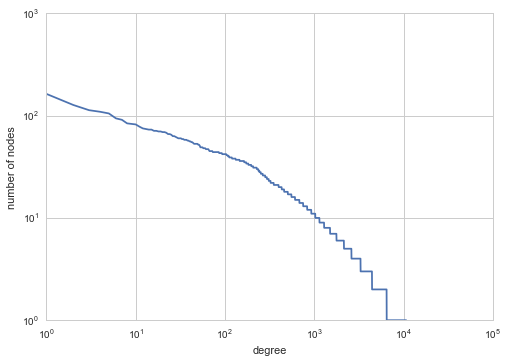

In [18]:
dd = sorted(centrality.DegreeCentrality(G).run().scores(), reverse=True)
plt.xscale("log")
plt.xlabel("degree")
plt.yscale("log")
plt.ylabel("number of nodes")
plt.plot(dd)
plt.show()

We choose a logarithmic scale on both axes because a _powerlaw degree distribution_, a characteristic feature of complex networks, would show up as a straight line from the top left to the bottom right on such a plot. As we see, the degree distribution of the `PGPgiantcompo` network is definitely skewed, with few high-degree nodes and many low-degree nodes. But does the distribution actually obey a power law? In order to study this, we need to apply the [powerlaw](https://pypi.python.org/pypi/powerlaw) module. Call the following function:

In [19]:
import powerlaw
fit = powerlaw.Fit(dd)

Calculating best minimal value for power law fit


The powerlaw coefficient can then be retrieved via:

In [20]:
fit.alpha

4.4185071392443591

If you further want to know how "good" it fits the power law distribution, you can use the the `distribution_compare`-function. From the documentation of the function: 
> R : float
>
> Loglikelihood ratio of the two distributions' fit to the data. If
> greater than 0, the first distribution is preferred. If less than
> 0, the second distribution is preferred.

> p : float
>
> Significance of R


In [21]:
fit.distribution_compare('power_law','exponential')

(10.90280164722239, 0.041197207672945678)

## Transitivity / Clustering Coefficients

In the most general sense, transitivity measures quantify how likely it is that the relations out of which the network is built are transitive. The clustering coefficient is the most prominent of such measures. We need to distinguish between global and local clustering coefficient: The global clustering coefficient for a network gives the fraction of closed triads. The local clustering coefficient focuses on a single node and counts how many of the possible edges between neighbors of the node exist. The average of this value over all nodes is a good indicator for the degreee of transitivity and the presence of community structures in a network, and this is what the following function returns:

In [22]:
globals.clustering(G)

0.44180491618170764

## Search and Shortest Paths

A simple breadth-first search from a starting node can be performed as follows:

In [23]:
v = 0
bfs = graph.BFS(G, v)
bfs.run()

bfsdist = bfs.getDistances()

The return value is a list of distances from `v` to other nodes - indexed by node id. For example, we can now calculate the mean distance from the starting node to all other nodes:

In [24]:
sum(bfsdist) / len(bfsdist)

11.339044943820225

Similarly, Dijkstra's algorithm yields shortest path distances from a starting node to all other nodes in a weighted graph. Because `PGPgiantcompo` is an unweighted graph, the result is the same here:

In [25]:
dijkstra = graph.Dijkstra(G, v)
dijkstra.run()
spdist = dijkstra.getDistances()
sum(spdist) / len(spdist)

11.339044943820225

## Core Decomposition

A $k$-core decomposition of a graph is performed by successicely peeling away nodes with degree less than $k$. The remaining nodes form the $k$-core of the graph.

In [26]:
K = readGraph("input/karate.graph",Format.METIS)
coreDec = centrality.CoreDecomposition(K)
coreDec.run()

Core decomposition assigns a core number to each node, being the maximum $k$ for which a node is contained in the $k$-core. For this small graph, core numbers have the following range:

In [27]:
set(coreDec.scores())

{1.0, 2.0, 3.0, 4.0}

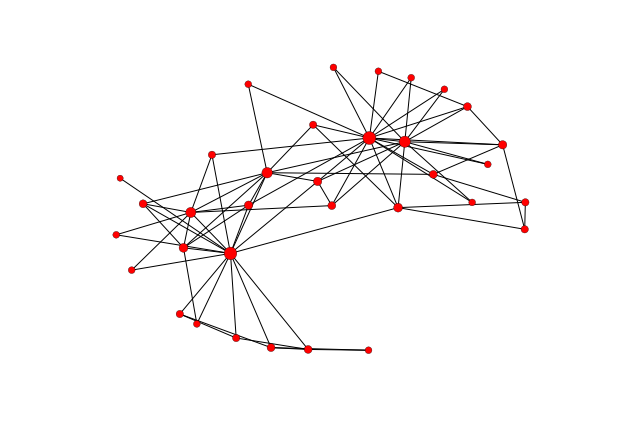

In [28]:
viztasks.drawGraph(K, nodeSizes=[(k**2)*20 for k in coreDec.scores()])
plt.show()

## Community Detection

This section demonstrates the community detection capabilities of NetworKit. Community detection is concerned with identifying groups of nodes which are significantly more densely connected to eachother than to the rest of the network.

Code for community detection is contained in the `community` module. The module provides a top-level function to quickly perform community detection with a suitable algorithm and print some stats about the result.

In [29]:
community.detectCommunities(G)

PLM(balanced,pc,turbo) detected communities in 0.25756025314331055 [s]
solution properties:
-------------------  ----------
# communities         93
min community size     6
max community size   682
avg. community size  114.839
modularity             0.881864
-------------------  ----------


The function prints some statistics and returns the partition object representing the communities in the network as an assignment of node to community label. Let's capture this result of the last function call.

In [30]:
communities = community.detectCommunities(G)

PLM(balanced,pc,turbo) detected communities in 0.09407258033752441 [s]
solution properties:
-------------------  ----------
# communities         98
min community size     6
max community size   656
avg. community size  108.98
modularity             0.881609
-------------------  ----------


*Modularity* is the primary measure for the quality of a community detection solution. The value is in the range `[-0.5,1]` and usually depends both on the performance of the algorithm and the presence of distinctive community structures in the network.

In [31]:
community.Modularity().getQuality(communities, G)

0.8816090951171207

### The Partition Data Structure

The result of community detection is a partition of the node set into disjoint subsets. It is represented by the `Partition` data strucure, which provides several methods for inspecting and manipulating a partition of a set of elements (which need not be the nodes of a graph).

In [32]:
type(communities)

_NetworKit.Partition

In [33]:
print("{0} elements assigned to {1} subsets".format(communities.numberOfElements(), communities.numberOfSubsets()))


10680 elements assigned to 98 subsets


In [34]:
print("the biggest subset has size {0}".format(max(communities.subsetSizes())))

the biggest subset has size 656


The contents of a partition object can be written to file in a simple format, in which each line *i* contains the subset id of node *i*.

In [35]:
community.writeCommunities(communities, "output/communties.partition")

wrote communities to: output/communties.partition


### Choice of Algorithm

The community detection function used a good default choice for an algorithm: *PLM*, our parallel implementation of the well-known Louvain method. It yields a high-quality solution at reasonably fast running times. Let us now apply a variation of this algorithm.

In [36]:
community.detectCommunities(G, algo=community.PLM(G, True))

PLM(balanced,refine,pc,turbo) detected communities in 0.10080695152282715 [s]
solution properties:
-------------------  ----------
# communities         96
min community size     6
max community size   683
avg. community size  111.25
modularity             0.883865
-------------------  ----------


We have switched on refinement, and we can see how modularity is slightly improved. For a small network like this, this takes only marginally longer.

### Visualizing the Result

We can easily plot the distribution of community sizes as follows. While the distribution is skewed, it does not seem to fit a power-law, as shown by a log-log plot.

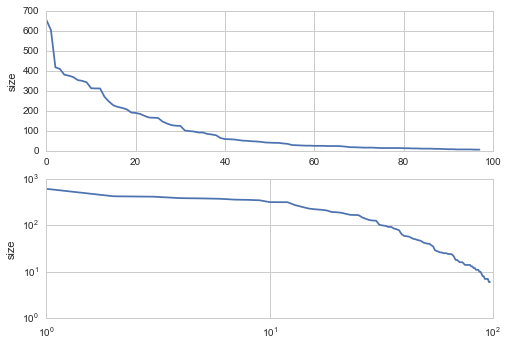

In [37]:
sizes = communities.subsetSizes()
sizes.sort(reverse=True)
ax1 = plt.subplot(2,1,1)
ax1.set_ylabel("size")
ax1.plot(sizes)

ax2 = plt.subplot(2,1,2)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylabel("size")
ax2.plot(sizes)
plt.show()

## Subgraph

NetworKit supports the creation of Subgraphs depending on an original graph and a set of nodes. This might be useful in case you want to analyze certain communities of a graph. Let's say that community 2 of the above result is of further interest, so we want a new graph that consists of nodes and intra cluster edges of community 2.

In [38]:
c2 = communities.getMembers(2)
g2 = G.subgraphFromNodes(c2)

In [39]:
communities.subsetSizeMap()[2]

166

In [40]:
g2.numberOfNodes()

166

As we can see, the number of nodes in our subgraph matches the number of nodes of community 2. The subgraph can be used like any other graph object, e.g. further community analysis:

In [41]:
communities2 = community.detectCommunities(g2)

PLM(balanced,pc,turbo) detected communities in 0.07078909873962402 [s]
solution properties:
-------------------  ---------
# communities        12
min community size    4
max community size   30
avg. community size  13.8333
modularity            0.752052
-------------------  ---------


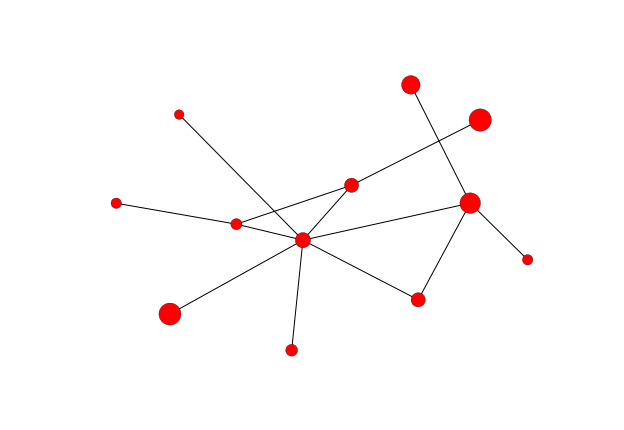

In [42]:
viztasks.drawCommunityGraph(g2,communities2)
plt.show()

## Centrality

[Centrality](http://en.wikipedia.org/wiki/Centrality) measures the relative importance of a node within a graph. Code for centrality analysis is grouped into the `centrality` module.

### Betweenness Centrality

We implement Brandes' algorithm for the exact calculation of betweenness centrality. While the algorithm is efficient, it still needs to calculate shortest paths between all pairs of nodes, so its scalability is limited. We demonstrate it here on the small Karate club graph.  

In [43]:
K = readGraph("input/karate.graph", Format.METIS)

In [44]:
bc = centrality.Betweenness(K)
bc.run()

We have now calculated centrality values for the given graph, and can retrieve them either as an ordered ranking of nodes or as a list of values indexed by node id. 

In [45]:
bc.ranking()[:10] # the 10 most central nodes

[(0, 462.14285714285717),
 (33, 321.1031746031745),
 (32, 153.38095238095238),
 (2, 151.70158730158732),
 (31, 146.0190476190476),
 (8, 59.05873015873016),
 (1, 56.95714285714285),
 (13, 48.43174603174603),
 (19, 34.2936507936508),
 (5, 31.666666666666668)]

### Approximation of Betweenness

Since exact calculation of betweenness scores is often out of reach, NetworKit provides an approximation algorithm based on path sampling. Here we estimate betweenness centrality in `PGPgiantcompo`, with a probabilistic guarantee that the error is no larger than an additive constant $\epsilon$.

In [46]:
abc = centrality.ApproxBetweenness(G, epsilon=0.1)
abc.run()

The 10 most central nodes according to betweenness are then

In [47]:
abc.ranking()[:10]

[(1143, 0.16365824308062585),
 (6655, 0.10589651022864024),
 (6555, 0.09025270758122747),
 (7297, 0.08303249097472928),
 (3156, 0.06859205776173288),
 (6744, 0.06618531889290014),
 (6932, 0.06498194945848378),
 (6098, 0.06257521058965104),
 (2258, 0.05655836341756921),
 (7369, 0.05174488567990374)]

### Eigenvector Centrality and PageRank

Eigenvector centrality and its variant PageRank assign relative importance to nodes according to their connections, incorporating the idea that edges to high-scoring nodes contribute more. PageRank is a version of eigenvector centrality which introduces a damping factor, modeling a random web surfer which at some point stops following links and jumps to a random page. In PageRank theory, centrality is understood as the probability of such a web surfer to arrive on a certain page. Our implementation of both measures is based on parallel power iteration, a relatively simple eigensolver.

In [48]:
# Eigenvector centrality
ec = centrality.EigenvectorCentrality(K)
ec.run()
ec.ranking()[:10] # the 10 most central nodes

[(33, 0.37335860763538437),
 (0, 0.3554879627576304),
 (2, 0.31719212126079693),
 (32, 0.308641699961726),
 (1, 0.2659584485486244),
 (8, 0.2274061452435449),
 (13, 0.22647475684342064),
 (3, 0.2111796960531623),
 (31, 0.19103658572493037),
 (30, 0.1747599501690216)]

In [49]:
# PageRank
pr = centrality.PageRank(K, 1e-6)
pr.run()
pr.ranking()[:10] # the 10 most central nodes

[(33, 0.02941190490185556),
 (0, 0.029411888071820155),
 (32, 0.02941184486730034),
 (1, 0.02941180477938106),
 (2, 0.02941179873364914),
 (3, 0.029411771282676906),
 (31, 0.029411770725212477),
 (5, 0.029411768995095993),
 (6, 0.029411768995095993),
 (23, 0.029411763985014328)]

## NetworkX Compatibility

[NetworkX](http://en.wikipedia.org/wiki/Centrality) is a popular Python package for network analysis. To let both packages complement eachother, and to enable the adaptation of existing NetworkX-based code, we support the conversion of the respective graph data structures.

In [50]:
import networkx as nx
nxG = nxadapter.nk2nx(G) # convert from NetworKit.Graph to networkx.Graph
print(nx.degree_assortativity_coefficient(nxG))

0.238211371708


## Generating Graphs

An important subfield of network science is the design and analysis of generative models. A variety of generative models have been proposed with the aim of reproducing one or several of the properties we find in real-world complex networks. NetworKit includes generator algorithms for several of them.

The **Erdös-Renyi model** is the most basic random graph model, in which each edge exists with the same uniform probability. NetworKit provides an efficient generator:

In [51]:
ERG = generators.ErdosRenyiGenerator(1000, 0.1).generate()
profiling.Profile.create(ERG, preset="minimal").show()

G#134 
 1000 
 50009 
 0.100118 
 False 
 False 
 0 
 N/A 
 N/A 
 1 
 
 
 
 <img src="data:image/svg+xml;utf8,%3Csvg%20height%3D%22180pt%22%20version%3D%221.1%22%20viewBox%3D%220%200%20288%20180%22%20width%3D%22288pt%22%20xmlns%3D%22http%3A%2F%2Fwww.w3.org%2F2000%2Fsvg%22%20xmlns%3Axlink%3D%22http%3A%2F%2Fwww.w3.org%2F1999%2Fxlink%22%3E%20%3Cdefs%3E%20%3Cstyle%20type%3D%22text%2Fcss%22%3E%20%2A%7Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Around%3Bstroke-miterlimit%3A100000%3B%7D%20%3C%2Fstyle%3E%20%3C%2Fdefs%3E%20%3Cg%20id%3D%22figure_1%22%3E%20%3Cg%20id%3D%22patch_1%22%3E%20%3Cpath%20d%3D%22M%200%20180%20L%20288%20180%20L%20288%200%20L%200%200%20z%20%22%20style%3D%22fill%3A%23ffffff%3B%22%2F%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22axes_1%22%3E%20%3Cg%20id%3D%22patch_2%22%3E%20%3Cpath%20d%3D%22M%2034.5625%20137.4%20L%20263.157812%20137.4%20L%20263.157812%2010.8%20L%2034.5625%2010.8%20z%20%22%20style%3D%22fill%3A%23ffffff%3B%22%2F%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22matplotlib.axis_1%22%3E%20%3Cg%20id%3D%22xtick_1%22%3E%20%3Cg%20id%3D%22line2d_1%22%3E%20%3Cpath%20clip-path%3D%22url%28%23p34f7a00139%29%22%20d%3D%22M%2035.730292%20137.4%20L%2035.730292%2010.8%20%22%20style%3D%22fill%3Anone%3Bstroke%3A%23d3d3d3%3Bstroke-linecap%3Around%3B%22%2F%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22line2d_2%22%3E%20%3Cdefs%3E%20%3Cpath%20d%3D%22M%200%200%20L%200%200%20%22%20id%3D%22mc84f59cb06%22%20style%3D%22stroke%3A%23d3d3d3%3B%22%2F%3E%20%3C%2Fdefs%3E%20%3Cg%3E%20%3Cuse%20style%3D%22fill%3A%23d3d3d3%3Bstroke%3A%23d3d3d3%3B%22%20x%3D%2235.7302921456%22%20xlink%3Ahref%3D%22%23mc84f59cb06%22%20y%3D%22137.4%22%2F%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22line2d_3%22%3E%20%3Cg%3E%20%3Cuse%20style%3D%22fill%3A%23d3d3d3%3Bstroke%3A%23d3d3d3%3B%22%20x%3D%2235.7302921456%22%20xlink%3Ahref%3D%22%23mc84f59cb06%22%20y%3D%2210.8%22%2F%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22text_1%22%3E%20%3C%21--%20%24%5Cmathdefault%7B70%7D%24%20--%3E%20%3Cdefs%3E%20%3Cpath%20d%3D%22M%204.15625%2035.296875%20Q%204.15625%2048%206.765625%2055.734375%20Q%209.375%2063.484375%2014.515625%2067.671875%20Q%2019.671875%2071.875%2027.484375%2071.875%20Q%2033.25%2071.875%2037.59375%2069.546875%20Q%2041.9375%2067.234375%2044.765625%2062.859375%20Q%2047.609375%2058.5%2049.21875%2052.21875%20Q%2050.828125%2045.953125%2050.828125%2035.296875%20Q%2050.828125%2022.703125%2048.234375%2014.96875%20Q%2045.65625%207.234375%2040.5%203%20Q%2035.359375%20-1.21875%2027.484375%20-1.21875%20Q%2017.140625%20-1.21875%2011.234375%206.203125%20Q%204.15625%2015.140625%204.15625%2035.296875%20M%2013.1875%2035.296875%20Q%2013.1875%2017.671875%2017.3125%2011.828125%20Q%2021.4375%206%2027.484375%206%20Q%2033.546875%206%2037.671875%2011.859375%20Q%2041.796875%2017.71875%2041.796875%2035.296875%20Q%2041.796875%2052.984375%2037.671875%2058.78125%20Q%2033.546875%2064.59375%2027.390625%2064.59375%20Q%2021.34375%2064.59375%2017.71875%2059.46875%20Q%2013.1875%2052.9375%2013.1875%2035.296875%20%22%20id%3D%22ArialMT-30%22%2F%3E%20%3Cpath%20d%3D%22M%204.734375%2062.203125%20L%204.734375%2070.65625%20L%2051.078125%2070.65625%20L%2051.078125%2063.8125%20Q%2044.234375%2056.546875%2037.515625%2044.484375%20Q%2030.8125%2032.421875%2027.15625%2019.671875%20Q%2024.515625%2010.6875%2023.78125%200%20L%2014.75%200%20Q%2014.890625%208.453125%2018.0625%2020.40625%20Q%2021.234375%2032.375%2027.171875%2043.484375%20Q%2033.109375%2054.59375%2039.796875%2062.203125%20z%20%22%20id%3D%22ArialMT-37%22%2F%3E%20%3C%2Fdefs%3E%20%3Cg%20transform%3D%22translate%2830.1302921456%20151.5578125%29scale%280.1%20-0.1%29%22%3E%20%3Cuse%20transform%3D%22translate%280.0%200.125%29%22%20xlink%3Ahref%3D%22%23ArialMT-37%22%2F%3E%20%3Cuse%20transform%3D%22translate%2855.615234375%200.125%29%22%20xlink%3Ahref%3D%22%23ArialMT-30%22%2F%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22xtick_2%22%3E%20%3Cg%20id%3D%22line2d_4%22%3E%20%3Cpath%20clip-path%3D%22url%28%23p34f7a00139%29%22%20d%3D%22M%2072.223797%20137.4%20L%2072.223797%2010.8%20%22%20style%3D%

A simple way to generate a **random graph with community structure** is to use the `ClusteredRandomGraphGenerator`. It uses a simple variant of the Erdös-Renyi model: The node set is partitioned into a given number of subsets. Nodes within the same subset have a higher edge probability.

In [52]:
CRG = generators.ClusteredRandomGraphGenerator(200, 4, 0.2, 0.002).generate()

In [53]:
community.detectCommunities(CRG)

PLM(balanced,pc,turbo) detected communities in 0.11079144477844238 [s]
solution properties:
-------------------  ---------
# communities         4
min community size   46
max community size   59
avg. community size  50
modularity            0.709948
-------------------  ---------


In [54]:
profiling.Profile.create(CRG, preset="minimal").show()

G#139 
 200 
 995 
 0.05 
 False 
 False 
 0 
 N/A 
 N/A 
 1 
 
 
 
 <img src="data:image/svg+xml;utf8,%3Csvg%20height%3D%22180pt%22%20version%3D%221.1%22%20viewBox%3D%220%200%20288%20180%22%20width%3D%22288pt%22%20xmlns%3D%22http%3A%2F%2Fwww.w3.org%2F2000%2Fsvg%22%20xmlns%3Axlink%3D%22http%3A%2F%2Fwww.w3.org%2F1999%2Fxlink%22%3E%20%3Cdefs%3E%20%3Cstyle%20type%3D%22text%2Fcss%22%3E%20%2A%7Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Around%3Bstroke-miterlimit%3A100000%3B%7D%20%3C%2Fstyle%3E%20%3C%2Fdefs%3E%20%3Cg%20id%3D%22figure_1%22%3E%20%3Cg%20id%3D%22patch_1%22%3E%20%3Cpath%20d%3D%22M%200%20180%20L%20288%20180%20L%20288%200%20L%200%200%20z%20%22%20style%3D%22fill%3A%23ffffff%3B%22%2F%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22axes_1%22%3E%20%3Cg%20id%3D%22patch_2%22%3E%20%3Cpath%20d%3D%22M%2029.05%20137.4%20L%20263.157812%20137.4%20L%20263.157812%2010.8%20L%2029.05%2010.8%20z%20%22%20style%3D%22fill%3A%23ffffff%3B%22%2F%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22matplotlib.axis_1%22%3E%20%3Cg%20id%3D%22xtick_1%22%3E%20%3Cg%20id%3D%22line2d_1%22%3E%20%3Cpath%20clip-path%3D%22url%28%23pfb368c36c4%29%22%20d%3D%22M%2063.2226%20137.4%20L%2063.2226%2010.8%20%22%20style%3D%22fill%3Anone%3Bstroke%3A%23d3d3d3%3Bstroke-linecap%3Around%3B%22%2F%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22line2d_2%22%3E%20%3Cdefs%3E%20%3Cpath%20d%3D%22M%200%200%20L%200%200%20%22%20id%3D%22md41d1bff3f%22%20style%3D%22stroke%3A%23d3d3d3%3B%22%2F%3E%20%3C%2Fdefs%3E%20%3Cg%3E%20%3Cuse%20style%3D%22fill%3A%23d3d3d3%3Bstroke%3A%23d3d3d3%3B%22%20x%3D%2263.2226000817%22%20xlink%3Ahref%3D%22%23md41d1bff3f%22%20y%3D%22137.4%22%2F%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22line2d_3%22%3E%20%3Cg%3E%20%3Cuse%20style%3D%22fill%3A%23d3d3d3%3Bstroke%3A%23d3d3d3%3B%22%20x%3D%2263.2226000817%22%20xlink%3Ahref%3D%22%23md41d1bff3f%22%20y%3D%2210.8%22%2F%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22text_1%22%3E%20%3C%21--%20%24%5Cmathdefault%7B5%7D%24%20--%3E%20%3Cdefs%3E%20%3Cpath%20d%3D%22M%204.15625%2018.75%20L%2013.375%2019.53125%20Q%2014.40625%2012.796875%2018.140625%209.390625%20Q%2021.875%206%2027.15625%206%20Q%2033.5%206%2037.890625%2010.78125%20Q%2042.28125%2015.578125%2042.28125%2023.484375%20Q%2042.28125%2031%2038.0625%2035.34375%20Q%2033.84375%2039.703125%2027%2039.703125%20Q%2022.75%2039.703125%2019.328125%2037.765625%20Q%2015.921875%2035.84375%2013.96875%2032.765625%20L%205.71875%2033.84375%20L%2012.640625%2070.609375%20L%2048.25%2070.609375%20L%2048.25%2062.203125%20L%2019.671875%2062.203125%20L%2015.828125%2042.96875%20Q%2022.265625%2047.46875%2029.34375%2047.46875%20Q%2038.71875%2047.46875%2045.15625%2040.96875%20Q%2051.609375%2034.46875%2051.609375%2024.265625%20Q%2051.609375%2014.546875%2045.953125%207.46875%20Q%2039.0625%20-1.21875%2027.15625%20-1.21875%20Q%2017.390625%20-1.21875%2011.203125%204.25%20Q%205.03125%209.71875%204.15625%2018.75%20%22%20id%3D%22ArialMT-35%22%2F%3E%20%3C%2Fdefs%3E%20%3Cg%20transform%3D%22translate%2860.4226000817%20151.5578125%29scale%280.1%20-0.1%29%22%3E%20%3Cuse%20transform%3D%22translate%280.0%200.390625%29%22%20xlink%3Ahref%3D%22%23ArialMT-35%22%2F%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22xtick_2%22%3E%20%3Cg%20id%3D%22line2d_4%22%3E%20%3Cpath%20clip-path%3D%22url%28%23pfb368c36c4%29%22%20d%3D%22M%20126.977451%20137.4%20L%20126.977451%2010.8%20%22%20style%3D%22fill%3Anone%3Bstroke%3A%23d3d3d3%3Bstroke-linecap%3Around%3B%22%2F%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22line2d_5%22%3E%20%3Cg%3E%20%3Cuse%20style%3D%22fill%3A%23d3d3d3%3Bstroke%3A%23d3d3d3%3B%22%20x%3D%22126.97745098%22%20xlink%3Ahref%3D%22%23md41d1bff3f%22%20y%3D%22137.4%22%2F%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22line2d_6%22%3E%20%3Cg%3E%20%3Cuse%20style%3D%22fill%3A%23d3d3d3%3Bstroke%3A%23d3d3d3%3B%22%20x%3D%22126.97745098%22%20xlink%3Ahref%3D%22%23md41d1bff3f%22%20y%3D%2210.8%22%2F%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22text_2%22%3E%20%3C%21--%20%24%5Cmathdefault%7B10%7D%24%20--%3E%20%3Cdefs%3E%20%3Cpath%20d%3D%22M%204.15625%2035.296875%20Q%204.15625%2048%206.76

The **Chung-Lu model** (also called **configuration model**) generates a random graph which corresponds to a given degree sequence, i.e. has the same expected degree sequence. It can therefore be used to replicate some of the properties of a given real networks, while others are not retained, such as high clustering and the specific community structure.

In [55]:
degreeSequence = [CRG.degree(v) for v in CRG.nodes()]
clgen = generators.ChungLuGenerator(degreeSequence)
CLG = clgen.generate()
community.detectCommunities(CLG)

PLM(balanced,pc,turbo) detected communities in 0.0008919239044189453 [s]
solution properties:
-------------------  ---------
# communities         7
min community size    1
max community size   43
avg. community size  28.5714
modularity            0.281093
-------------------  ---------


In [56]:
profiling.Profile.create(CLG, preset="minimal").show()

G#150 
 200 
 929 
 0.0466834 
 False 
 False 
 0 
 N/A 
 N/A 
 2 
 
 
 
 <img src="data:image/svg+xml;utf8,%3Csvg%20height%3D%22180pt%22%20version%3D%221.1%22%20viewBox%3D%220%200%20288%20180%22%20width%3D%22288pt%22%20xmlns%3D%22http%3A%2F%2Fwww.w3.org%2F2000%2Fsvg%22%20xmlns%3Axlink%3D%22http%3A%2F%2Fwww.w3.org%2F1999%2Fxlink%22%3E%20%3Cdefs%3E%20%3Cstyle%20type%3D%22text%2Fcss%22%3E%20%2A%7Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Around%3Bstroke-miterlimit%3A100000%3B%7D%20%3C%2Fstyle%3E%20%3C%2Fdefs%3E%20%3Cg%20id%3D%22figure_1%22%3E%20%3Cg%20id%3D%22patch_1%22%3E%20%3Cpath%20d%3D%22M%200%20180%20L%20288%20180%20L%20288%200%20L%200%200%20z%20%22%20style%3D%22fill%3A%23ffffff%3B%22%2F%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22axes_1%22%3E%20%3Cg%20id%3D%22patch_2%22%3E%20%3Cpath%20d%3D%22M%2029.05%20137.4%20L%20263.157812%20137.4%20L%20263.157812%2013.373964%20L%2029.05%2013.373964%20z%20%22%20style%3D%22fill%3A%23ffffff%3B%22%2F%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22matplotlib.axis_1%22%3E%20%3Cg%20id%3D%22xtick_1%22%3E%20%3Cg%20id%3D%22line2d_1%22%3E%20%3Cpath%20clip-path%3D%22url%28%23pf5552a491c%29%22%20d%3D%22M%2037.72066%20137.4%20L%2037.72066%2013.373964%20%22%20style%3D%22fill%3Anone%3Bstroke%3A%23d3d3d3%3Bstroke-linecap%3Around%3B%22%2F%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22line2d_2%22%3E%20%3Cdefs%3E%20%3Cpath%20d%3D%22M%200%200%20L%200%200%20%22%20id%3D%22m73e159d5e8%22%20style%3D%22stroke%3A%23d3d3d3%3B%22%2F%3E%20%3C%2Fdefs%3E%20%3Cg%3E%20%3Cuse%20style%3D%22fill%3A%23d3d3d3%3Bstroke%3A%23d3d3d3%3B%22%20x%3D%2237.7206597222%22%20xlink%3Ahref%3D%22%23m73e159d5e8%22%20y%3D%22137.4%22%2F%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22line2d_3%22%3E%20%3Cg%3E%20%3Cuse%20style%3D%22fill%3A%23d3d3d3%3Bstroke%3A%23d3d3d3%3B%22%20x%3D%2237.7206597222%22%20xlink%3Ahref%3D%22%23m73e159d5e8%22%20y%3D%2213.373964497%22%2F%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22text_1%22%3E%20%3C%21--%20%24%5Cmathdefault%7B0%7D%24%20--%3E%20%3Cdefs%3E%20%3Cpath%20d%3D%22M%204.15625%2035.296875%20Q%204.15625%2048%206.765625%2055.734375%20Q%209.375%2063.484375%2014.515625%2067.671875%20Q%2019.671875%2071.875%2027.484375%2071.875%20Q%2033.25%2071.875%2037.59375%2069.546875%20Q%2041.9375%2067.234375%2044.765625%2062.859375%20Q%2047.609375%2058.5%2049.21875%2052.21875%20Q%2050.828125%2045.953125%2050.828125%2035.296875%20Q%2050.828125%2022.703125%2048.234375%2014.96875%20Q%2045.65625%207.234375%2040.5%203%20Q%2035.359375%20-1.21875%2027.484375%20-1.21875%20Q%2017.140625%20-1.21875%2011.234375%206.203125%20Q%204.15625%2015.140625%204.15625%2035.296875%20M%2013.1875%2035.296875%20Q%2013.1875%2017.671875%2017.3125%2011.828125%20Q%2021.4375%206%2027.484375%206%20Q%2033.546875%206%2037.671875%2011.859375%20Q%2041.796875%2017.71875%2041.796875%2035.296875%20Q%2041.796875%2052.984375%2037.671875%2058.78125%20Q%2033.546875%2064.59375%2027.390625%2064.59375%20Q%2021.34375%2064.59375%2017.71875%2059.46875%20Q%2013.1875%2052.9375%2013.1875%2035.296875%20%22%20id%3D%22ArialMT-30%22%2F%3E%20%3C%2Fdefs%3E%20%3Cg%20transform%3D%22translate%2834.9206597222%20151.5578125%29scale%280.1%20-0.1%29%22%3E%20%3Cuse%20transform%3D%22translate%280.0%200.125%29%22%20xlink%3Ahref%3D%22%23ArialMT-30%22%2F%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22xtick_2%22%3E%20%3Cg%20id%3D%22line2d_4%22%3E%20%3Cpath%20clip-path%3D%22url%28%23pf5552a491c%29%22%20d%3D%22M%2086.985772%20137.4%20L%2086.985772%2013.373964%20%22%20style%3D%22fill%3Anone%3Bstroke%3A%23d3d3d3%3Bstroke-linecap%3Around%3B%22%2F%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22line2d_5%22%3E%20%3Cg%3E%20%3Cuse%20style%3D%22fill%3A%23d3d3d3%3Bstroke%3A%23d3d3d3%3B%22%20x%3D%2286.9857717803%22%20xlink%3Ahref%3D%22%23m73e159d5e8%22%20y%3D%22137.4%22%2F%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22line2d_6%22%3E%20%3Cg%3E%20%3Cuse%20style%3D%22fill%3A%23d3d3d3%3Bstroke%3A%23d3d3d3%3B%22%20x%3D%2286.9857717803%22%20xlink%3Ahref%3D%22%23m73e159d5e8%22%20y%3D%2213.373964497%22%2F%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22text_

## Settings

In this section we discuss global settings.

### Logging

When using NetworKit from the command line, the verbosity of console output can be controlled via several loglevels, from least to most verbose: `FATAL`, `ERROR`, `WARN`, `INFO`, `DEBUG` and `TRACE`. (Currently, logging is only available on the console and not visible in the IPython Notebook). 

In [57]:
getLogLevel() # the default loglevel

'ERROR'

In [58]:
setLogLevel("TRACE") # set to most verbose mode
setLogLevel("ERROR") # set back to default

Please note, that the default build setting is optimized (`--optimize=Opt`) and thus, every LOG statement below INFO is removed. If you need DEBUG and TRACE statements, please build the extension module by appending `--optimize=Dbg` when calling the setup script.

### Parallelism

The degree of parallelism can be controlled and monitored in the following way:

In [59]:
setNumberOfThreads(4) # set the maximum number of available threads

In [60]:
getMaxNumberOfThreads() # see maximum number of available threads

4

In [61]:
getCurrentNumberOfThreads() # the number of threads currently executing

1

## Support

NetworKit is an open-source project that improves with suggestions and contributions from its users. The email list `networkit@ira.uni-karlsruhe.de` is the place for general discussion and questions.